# Binary Classification

## Imports and Setup

In [1]:
import arviz as az
import bambi as bmb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from typing import List
from bambi import plots as bmb_plots
from matplotlib.lines import Line2D
from scipy import special, stats
import statsmodels.formula.api as smf

rng_seed = np.random.RandomState(seed=12)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

# Data Generation

* Generate two classes, each with different probability of "success"

In [3]:
def generate_bernoulli_df(p1: float, n1: int, p2: float, n2: int,
                          rng_seed: np.random.RandomState=rng_seed) -> pd.DataFrame:

    samples_1 = stats.bernoulli.rvs(p=p1, size=n1, random_state=rng_seed)
    samples_2 = stats.bernoulli.rvs(p=p2, size=n2, random_state=rng_seed)
    samples = np.concatenate([samples_1, samples_2])
    batches = ["Batch 1"] * n1 + ["Batch 2"] * n1
    df_samples = pd.DataFrame({"result": samples, "batch": batches})
    return df_samples

Let's check the empirical success probabilities are close to the underlying true values.

In [4]:
p1 = 0.2
p2 = 0.8
n1 = 100
n2 = 100

df_samples = generate_bernoulli_df(p1=p1, n1=n1, p2=p2, n2=n2)
df_samples.head()

,result,batch
0,0,Batch 1
1,0,Batch 1
2,0,Batch 1
3,0,Batch 1
4,0,Batch 1


In [5]:
samples_summarized = (
    df_samples
        .groupby("batch")
        .agg(n=("result", len), successes=("result", "sum"), p=("result", "mean"))
)
samples_summarized

,n,successes,p
batch,,,
Batch 1,100,23,0.23
Batch 2,100,81,0.81


In [6]:
n1_large = 1_000
n2_large = 1_000
df_large_samples = generate_bernoulli_df(p1=p1, n1=n1_large, p2=p2, n2=n2_large)
large_samples_summarized = (
    df_large_samples
        .groupby("batch")
        .agg(n=("result", len), successes=("result", "sum"), p=("result", "mean"))
)
large_samples_summarized

,n,successes,p
batch,,,
Batch 1,1000,225,0.225
Batch 2,1000,805,0.805


### Part 1: Beta Bernoulli (or Binomial) model

Code a model in PyMC using a Beta prior. Feel free to use either a Bernoulli or Binomial likelihood. After coding the model verify that the posterior estimates the probabilities set above. After doing so 

1. Adjust the latent probability. Rerun the model and verify the results. Did your model recover those parameters?
2. Change the number of samples, Rerun the model and compare posteriors with a small number of samples vs a larger number

Bonus points for

* Only using one PyMC model context to estimate the latent probability of each group
* Coding this same model in Bambi

## Choose Prior
* `pm.find_constrained_prior`- helps find 

In [7]:
df_samples.loc[df_samples["batch"] == "Batch 1", "result"].mean()

0.23

In [8]:
batch1_mean = df_samples.loc[df_samples["batch"] == "Batch 1", "result"].mean()

In [9]:
MASS = 0.95  # 95 of the mass is within LOWER and UPPER
LOWER1 = batch1_mean - 0.1
UPPER1 = batch1_mean + 0.1
constrained_priors = pm.find_constrained_prior(
    distribution=pm.Beta,
    lower=LOWER1,
    upper=UPPER1,
    mass=MASS,
    init_guess=dict(alpha=1, beta=1))

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701

In [11]:
constrained_priors

{'alpha': 14.682667291711265, 'beta': 50.106519232510415}

In [12]:
# Write code here
with pm.Model() as beta1_prior:
    beta1 = pm.Beta("beta1", **constrained_priors)

beta1_draws = pm.draw(beta1, draws=10_000)

In [13]:
beta1_draws
# equivalent to
# stats.beta(a=constrained_priors['alpha'], b=constrained_priors['beta']).rvs(10_000)

array([0.19604161, 0.30458601, 0.23512299, ..., 0.24213173, 0.24144942,
       0.2119518 ])

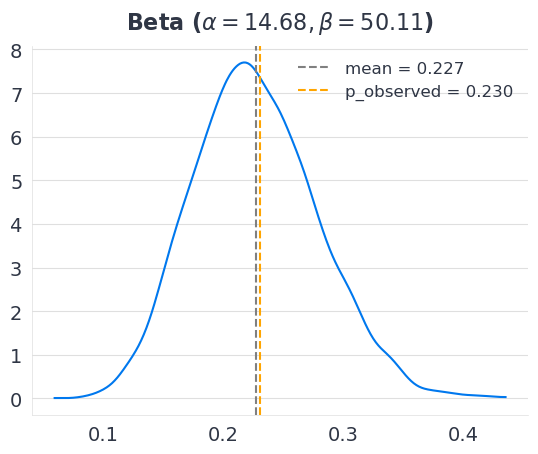

In [15]:
ax = az.plot_dist(beta1_draws)
ax.set_title(fr"Beta ($\alpha={constrained_priors['alpha']:.2f},\beta={constrained_priors['beta']:.2f}$)");
ax.axvline(beta1_draws.mean(), color="gray", ls="--", label=f"mean = {beta1_draws.mean():.3f}")
ax.axvline(batch1_mean, color="orange", ls="--", label=f"p_observed = {batch1_mean:.3f}")
ax.legend();

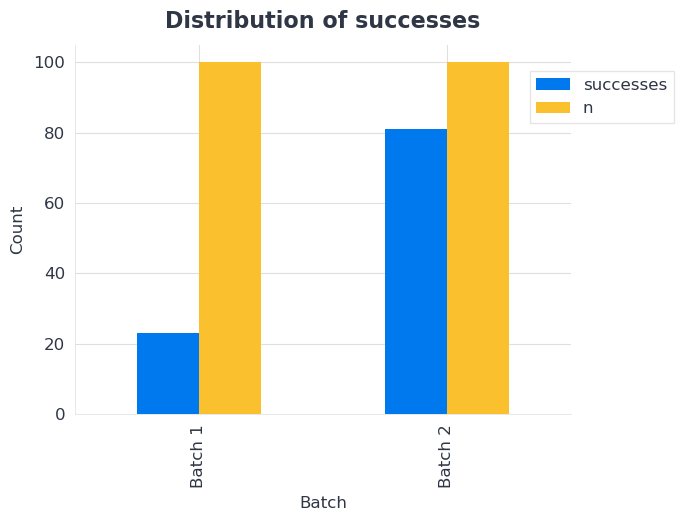

In [28]:
fig, ax = plt.subplots()
samples_summarized[["successes", "n"]].plot(kind="bar", ax=ax)
ax.set(xlabel="Batch", ylabel="Count", title="Distribution of successes")
ax.legend(bbox_to_anchor=(0.9, 0.95), frameon=True);

In [18]:
samples_summarized

,n,successes,p
batch,,,
Batch 1,100,23,0.23
Batch 2,100,81,0.81


In [30]:
n = samples_summarized["n"].to_numpy()
successes = samples_summarized["successes"].to_numpy()
# single p for each experiment
bin_coords = {"batch": samples_summarized.index}  

In [29]:
large_samples_summarized

,n,successes,p
batch,,,
Batch 1,1000,225,0.225
Batch 2,1000,805,0.805


In [31]:
large_n = large_samples_summarized["n"].to_numpy()
large_successes = large_samples_summarized["successes"].to_numpy()
large_bin_coords = {"batch": large_samples_summarized.index} 

## Beta prior and Binomial Likelihood
* sampling based on the aggregated data in each class (batch)
    * a single n, #(success) and p for each batch

In [32]:
with pm.Model(coords=bin_coords) as bin_model:
    """Beta prior and Binomial likelihood"""
    p_bin = pm.Beta("p",2, 2, dims="batch")
    pm.Binomial("y", p=p_bin, n=n, observed=successes)

    # sampling
    bin_idata = pm.sample(chains=4, random_seed=1234)
    bin_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(
        bin_idata,
        extend_inferencedata=True,
        random_seed=1234,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [p, y]
Sampling: [y]


In [33]:
with pm.Model(coords=large_bin_coords) as large_bin_model:
    """Beta prior and Binomial likelihood"""
    large_p_bin = pm.Beta("p",2, 2, dims="batch")
    pm.Binomial("y", p=large_p_bin, n=large_n, observed=large_successes)
    
    # sampling
    large_bin_idata = pm.sample(chains=4, random_seed=1234)
    large_bin_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(
        large_bin_idata,
        extend_inferencedata=True,
        random_seed=1234,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [p, y]
Sampling: [y]


In [34]:
az.summary(bin_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p[Batch 1],0.241,0.042,0.163,0.322
p[Batch 2],0.799,0.039,0.726,0.868


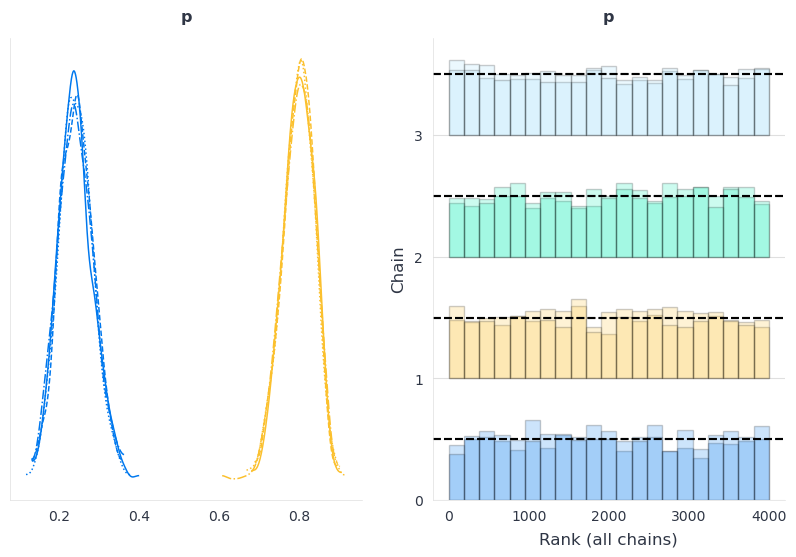

In [35]:
az.plot_trace(bin_idata, kind="rank_bars", figsize=(10, 6));

In [27]:
az.summary(large_bin_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p[Batch 1],0.226,0.013,0.201,0.250
p[Batch 2],0.804,0.012,0.781,0.827


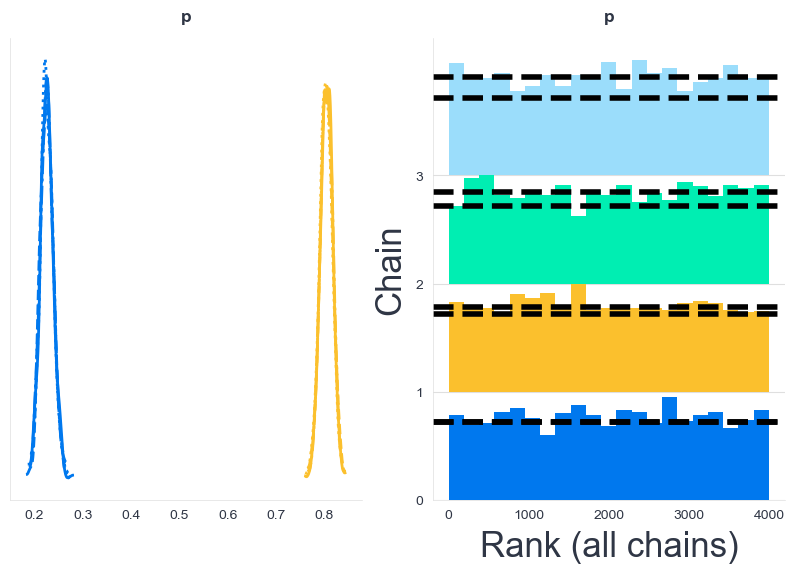

In [28]:
az.plot_trace(large_bin_idata, kind="rank_bars", figsize=(10, 6));

In [40]:
print(f"p1 = {p1}\np2 = {p2}")

p1 = 0.2
p2 = 0.8


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

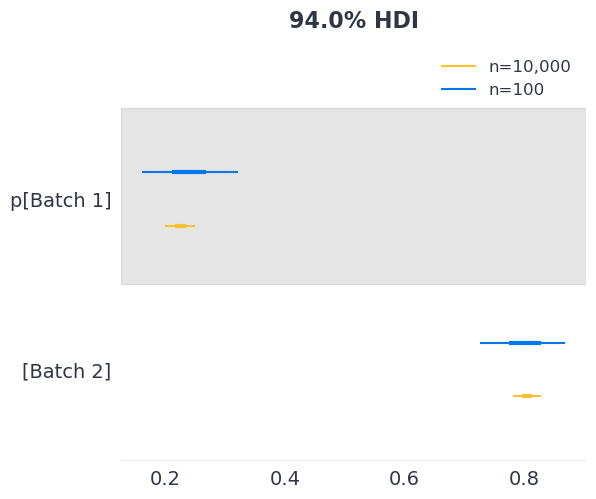

In [36]:
az.plot_forest([bin_idata, large_bin_idata], model_names=["n=100", "n=10,000"], combined=True)

## Beta prior and Bernoulli Likelihood
* each row is a (Bernoulli) experiment
    * two main types of experiments

In [43]:
batch, batch_idx = np.unique(df_samples["batch"], return_inverse=True)
ber_coords = {"batch": batch}
ber_coords

{'batch': array(['Batch 1', 'Batch 2'], dtype=object)}

In [45]:
large_batch, large_batch_idx = np.unique(df_large_samples["batch"], return_inverse=True)
large_ber_coords = {"batch": large_batch}
ber_coords

{'batch': array(['Batch 1', 'Batch 2'], dtype=object)}

In [46]:
with pm.Model(coords=ber_coords) as ber_model:
    """Beta prior and Bernoulli likelihood"""
    # different p for each experiment (batch)
    p_ber = pm.Beta("p",2, 2, dims="batch")  
    pm.Bernoulli("y", p=p_ber[batch_idx], observed=df_samples["result"].to_numpy())  
    # p=p_ber[batch_idx]- set p to the relevant trial

    # sampling
    ber_idata = pm.sample(chains=4, random_seed=1234)
    ber_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(
        ber_idata,
        extend_inferencedata=True,
        random_seed=1234,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [p, y]
Sampling: [y]


In [47]:
with pm.Model(coords=large_ber_coords) as large_ber_model:
    """Beta prior and Bernoulli likelihood"""
    p_ber = pm.Beta("p",2, 2, dims="batch")  # different p for each experiment (batch)
    pm.Bernoulli("y", p=p_ber[large_batch_idx], observed=df_large_samples["result"])  
    # p=p_ber[batch_idx]- set p to the relevant trial
    
    # sampling
    large_ber_idata = pm.sample(chains=4, random_seed=1234)
    large_ber_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(
        large_ber_idata,
        extend_inferencedata=True,
        random_seed=1234,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [p, y]
Sampling: [y]


In [48]:
az.summary(ber_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p[Batch 1],0.241,0.042,0.163,0.322
p[Batch 2],0.799,0.039,0.726,0.868


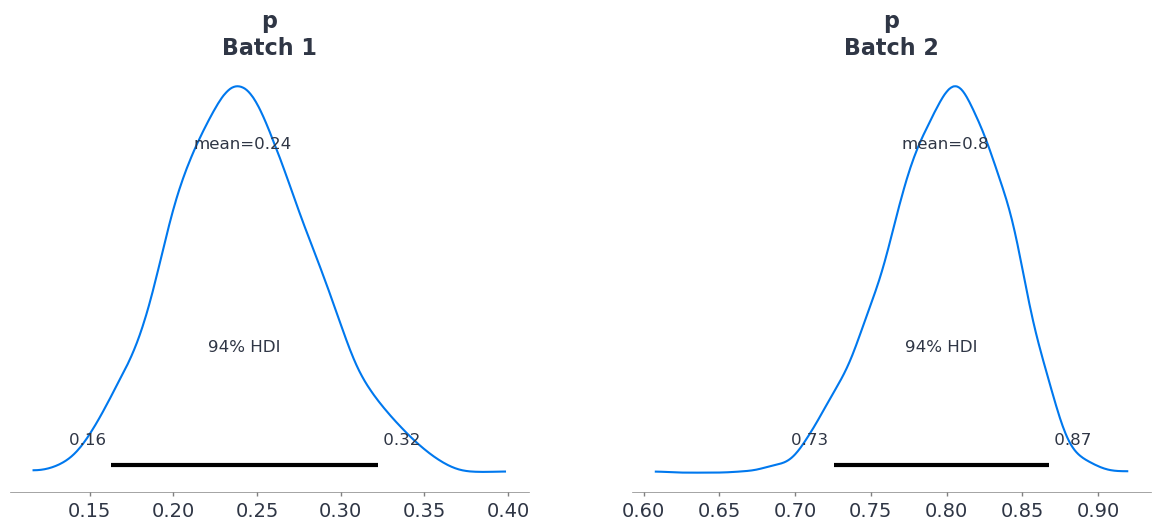

In [49]:
az.plot_posterior(ber_idata);

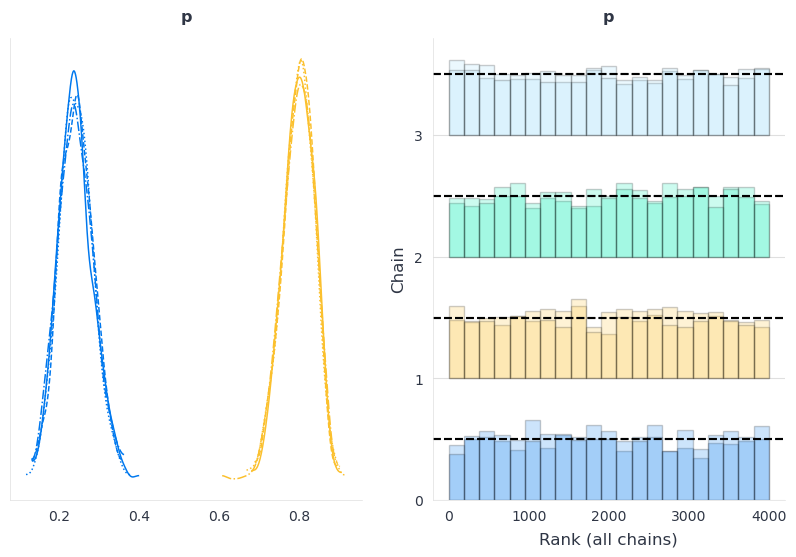

In [52]:
az.plot_trace(ber_idata, kind="rank_bars", figsize=(10, 6));

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

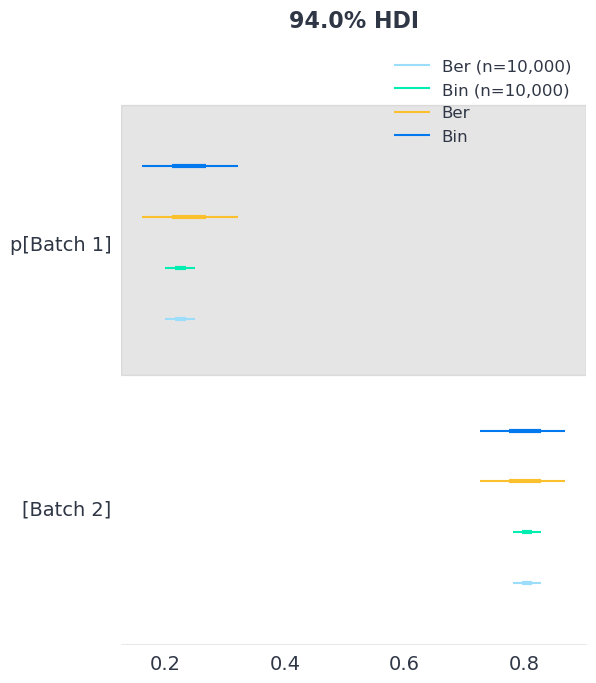

In [54]:
 az.plot_forest(
        [bin_idata, ber_idata, large_bin_idata, large_ber_idata],
        model_names=["Bin", "Ber", "Bin (n=10,000)", "Ber (n=10,000)"],
        combined=True)

### Bambi



#### Beta prior and Bernoulli likelihood

In [39]:
df_samples

,result,batch
0,0,Batch 1
1,0,Batch 1
2,0,Batch 1
3,0,Batch 1
4,0,Batch 1
...,...,...
195,1,Batch 2
196,1,Batch 2
197,0,Batch 2
198,0,Batch 2


In [55]:
priors = {"batch": bmb.Prior("Beta", alpha=2, beta=2)}
bmb_ber_model = bmb.Model(
    formula="result ~ 0 + batch",
    data=df_samples,
    family="bernoulli",
    link="identity",  # no need for logit since Beta dist. is already bounded between 0 and 1
    priors=priors
)
bmb_ber_idata = bmb_ber_model.fit(chains=4, random_seed=1234)

Modeling the probability that result==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [batch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [56]:
az.summary(bmb_ber_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batch[Batch 1],0.241,0.042,0.163,0.322,0.001,0.0,4660.0,2871.0,1.0
batch[Batch 2],0.799,0.039,0.726,0.868,0.001,0.0,4483.0,3189.0,1.0


In [43]:
samples_summarized

,n,successes,p
batch,,,
Batch 1,100,23,0.23
Batch 2,100,81,0.81


#### Beta prior, and Binomial likelihood
*  `p(x, n)`- model the proportion resulting from dividing x over n
    * function for the response term

In [44]:
priors = {"batch": bmb.Prior("Beta", alpha=2, beta=2)}
bmb_bin_model = bmb.Model(
    formula="p(successes, n) ~ 0 + batch",
    data=samples_summarized.reset_index(),
    family="binomial",  
    link="identity",  # no need for logit since Beta dist. is already bounded between 0 and 1
    priors=priors
)
bmb_bin_idata = bmb_bin_model.fit(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [45]:
az.summary(bmb_bin_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batch[Batch 1],0.241,0.042,0.163,0.322,0.001,0.0,4660.0,2871.0,1.0
batch[Batch 2],0.799,0.039,0.726,0.868,0.001,0.0,4483.0,3189.0,1.0


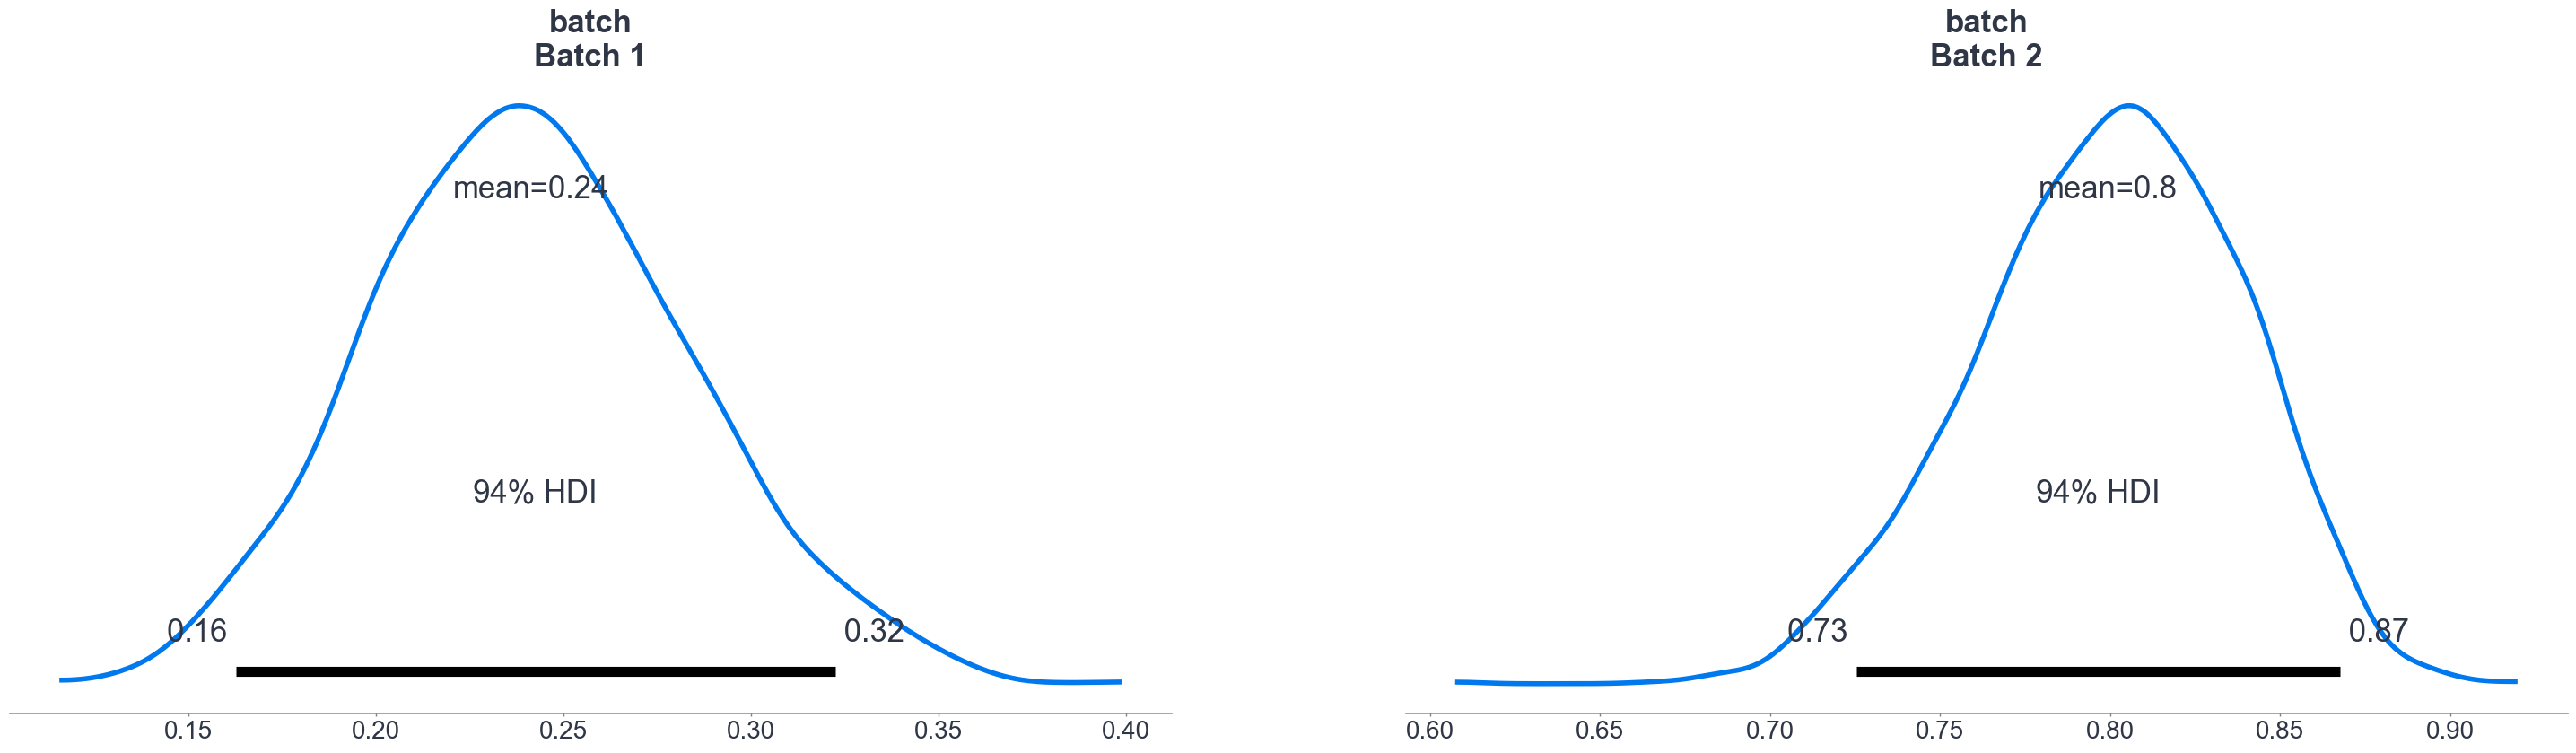

In [46]:
# Visualize posterior here
az.plot_posterior(bmb_ber_idata);

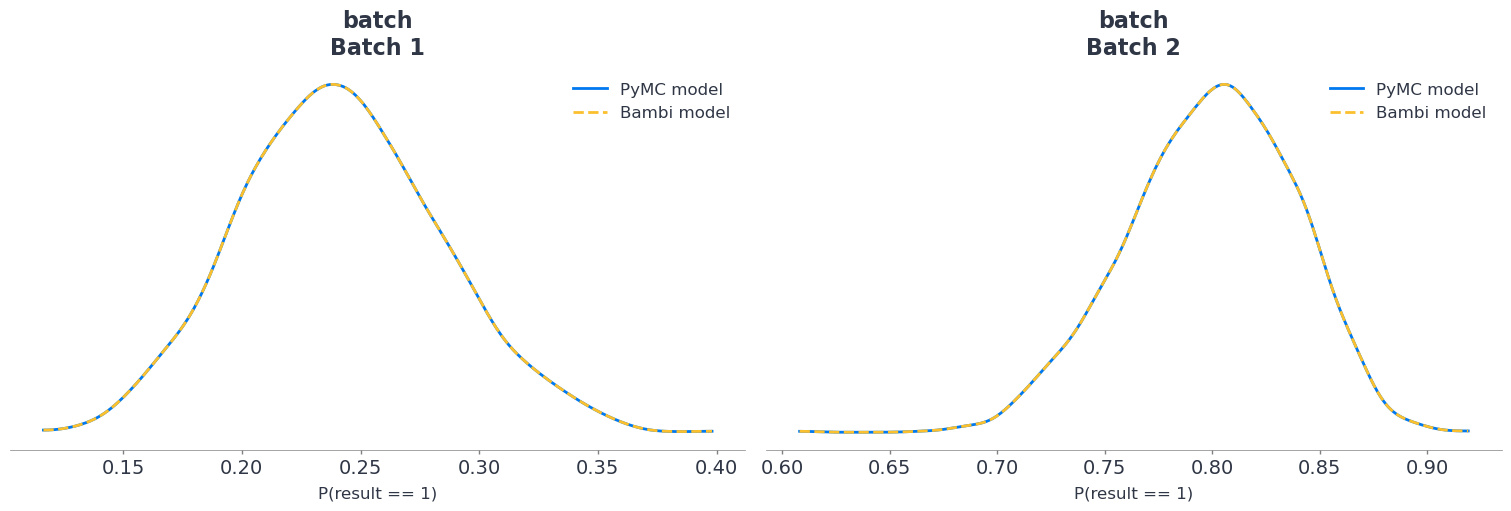

In [57]:
# Compare to pymc posterior here
fig, axes = plt.subplots(1, 2, figsize=(15, 5), layout="constrained")
axes = az.plot_posterior(
    ber_idata.posterior["p"],
    hdi_prob="hide",
    point_estimate=None,
    lw=2,
    label="PyMC model",
    ax=axes
)
az.plot_posterior(
    bmb_ber_idata.posterior["batch"],
    hdi_prob="hide", 
    point_estimate=None,
    color="C1",
    lw=2,
    ls="--",
    label="Bambi model",
    ax=axes, 
)
axes[0].set(xlabel="P(result == 1)")
axes[1].set(xlabel="P(result == 1)");

# Logistic regression model

## Logistic regression model with PyMC

In [48]:
df_samples.head()

,result,batch
0,0,Batch 1
1,0,Batch 1
2,0,Batch 1
3,0,Batch 1
4,0,Batch 1


In [58]:
batch, batch_idx = np.unique(df_samples["batch"], return_inverse=True)
coords = {"batch": batch}

In [59]:
with pm.Model(coords=coords) as lr_model:
    # set parametrer (prior)
    β = pm.Normal("β", 0, 1, dims="batch")  # set different β for each experiment
    p = pm.Deterministic("p", pm.math.sigmoid(β))  # convert into prob.
    # likelihood (for each observation)
    pm.Bernoulli("result", p=p[batch_idx], observed=df_samples["result"])

    lr_idata = pm.sample(chains=4, random_seed=1234)
    lr_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(
        lr_idata,
        extend_inferencedata=True,
        random_seed=1234)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [result, β]
Sampling: [result]


In [60]:
az.summary(lr_idata)  #  var_names="p"

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[Batch 1],-1.159,0.231,-1.619,-0.752,0.004,0.003,3691.0,2949.0,1.0
β[Batch 2],1.379,0.240,0.933,1.830,0.004,0.003,4155.0,3051.0,1.0
p[0],0.241,0.042,0.165,0.319,0.001,0.000,3691.0,2949.0,1.0
p[1],0.796,0.038,0.725,0.868,0.001,0.000,4155.0,3051.0,1.0


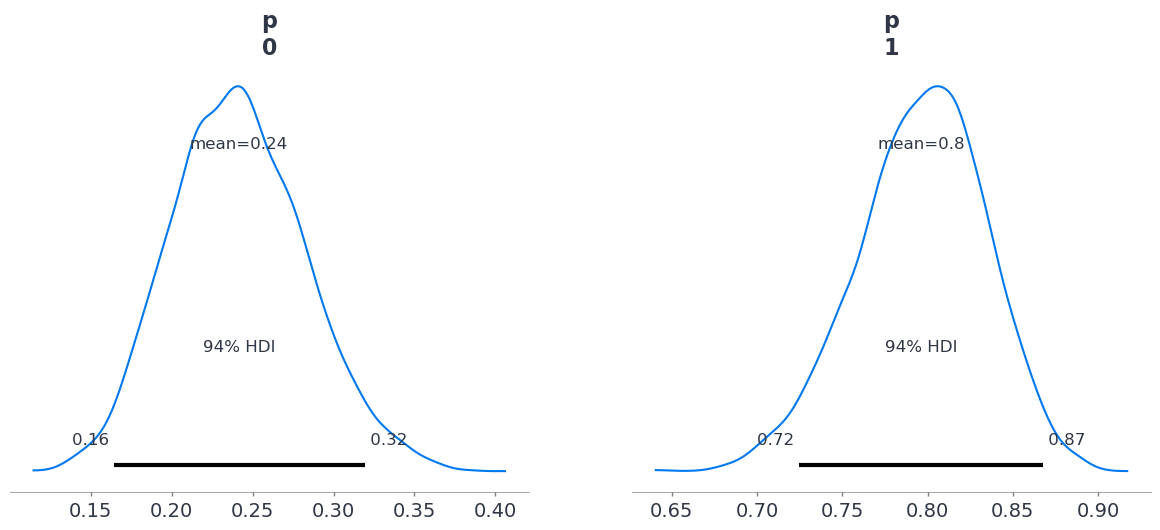

In [63]:
az.plot_posterior(lr_idata, var_names="p");

## Logistic regression model with Bambi


In [64]:
lr_bmb_model = bmb.Model(formula="result ~ 0 + batch", data=df_samples, family="bernoulli", link="logit")
lr_bmb_idata = lr_bmb_model.fit(chains=4, random_seed=1234)

Modeling the probability that result==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [batch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [65]:
# summary of estimated probabilities (using sigmoid (expit))
prob_summary = az.summary(special.expit(lr_bmb_idata.posterior["batch"]))
prob_summary.index = ["p[0]", "p[1]"]
prob_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.231,0.042,0.151,0.31,0.001,0.0,4533.0,2951.0,1.0
p[1],0.810,0.039,0.735,0.88,0.001,0.0,4296.0,2964.0,1.0


In [66]:
df_samples.groupby("batch")["result"].mean()

batch
Batch 1    0.23
Batch 2    0.81
Name: result, dtype: float64

In [67]:
pd.concat(
    [az.summary(lr_bmb_idata),
     prob_summary
     ])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batch[Batch 1],-1.217,0.239,-1.665,-0.762,0.004,0.003,4533.0,2951.0,1.0
batch[Batch 2],1.473,0.259,0.993,1.952,0.004,0.003,4296.0,2964.0,1.0
p[0],0.231,0.042,0.151,0.310,0.001,0.000,4533.0,2951.0,1.0
p[1],0.810,0.039,0.735,0.880,0.001,0.000,4296.0,2964.0,1.0


# Predicting Penguins
* we want to see if we can classify Adelie Penguins from Chinstrap penguns using their physical features. 
* in this case we'll be using their bill length ot predict the species.

### Data Loading
* `bill_length_mm`: Bill length in millimeters
* `species`: A categorical column that indicates which species the observation is for

For reference the Palmer penguins dataset includes as number of numerical attributes of the penguin. A [full description](https://allisonhorst.github.io/palmerpenguins/) is available on the github page.

Let's now see if we can Bambi to predict which penguin is which based off of its `bill_length`.

In [84]:
penguins = pd.read_csv("../data/penguins.csv")
missing_data = penguins["bill_length_mm"].isnull()

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
penguins_filtered = penguins.loc[species_filter]

penguins_observed = penguins_filtered.iloc[:-5, :]

In [85]:
penguins_observed.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


## Exploratory Data Analysis
Plot the species as a function of bill length. 

In [86]:
penguins_observed.groupby("species")["bill_length_mm"].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
Adelie,151.0,38.791391,2.663405,32.1,36.75,38.8,40.75,46.0
Chinstrap,63.0,48.742857,3.270775,40.9,46.30,49.3,51.15,58.0


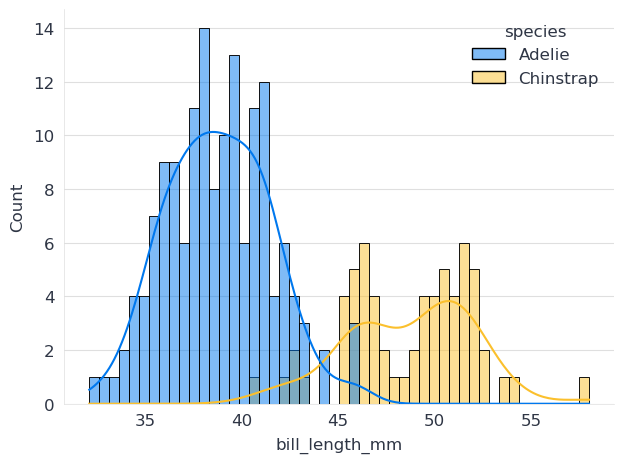

In [90]:
sns.histplot(x="bill_length_mm", hue="species", kde=True, bins=50, data=penguins_observed)
plt.tight_layout()
plt.show()

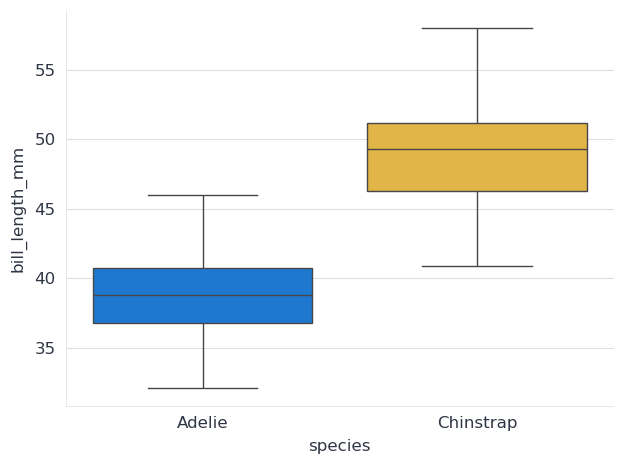

In [101]:
sns.boxplot(x="species", y="bill_length_mm", hue="species", data=penguins_observed)
plt.tight_layout()
plt.show()

### Bambi Logistic Regression Model


In [102]:
# In this answer Chinstrip ensure the penguin that is encoded 1 to match the plot above
penguins_lr_model = bmb.Model(
    formula="species['Chinstrap'] ~ 1 + bill_length_mm",
    data=penguins_observed,
    family="bernoulli",
    link="logit")
penguins_lr_idata = penguins_lr_model.fit(chains=4, random_seed=1234)
print(penguins_lr_model)

Modeling the probability that species==Chinstrap
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, bill_length_mm]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


       Formula: species['Chinstrap'] ~ 1 + bill_length_mm
        Family: bernoulli
          Link: p = logit
  Observations: 214
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 19.6485)
            bill_length_mm ~ Normal(mu: 0.0, sigma: 0.4671)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


In [103]:
az.summary(penguins_lr_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-43.382,6.598,-55.664,-31.125,0.172,0.121,1462.0,1829.0,1.0
bill_length_mm,0.981,0.151,0.696,1.256,0.004,0.003,1508.0,2003.0,1.0


### Predictions


In [104]:
# returns the draws from the posterior predictive distribution (need observed values)
penguins_lr_model.predict(penguins_lr_idata, inplace=True, kind="pps", data=penguins_observed)

In [108]:
def target_scatter_plot(
    ax, df: pd.DataFrame, target_names: List[str], target_vals: List[int], target_colors: List[str],
    scale: float=0.02, target_col: str="species", feature_col: str="bill_length_mm",
    rng_seed: np.random.RandomState=rng_seed, **ax_kwargs):
    """add scatter plot for each example and its (perturbed) class"""
    for target_name, target_val, color in zip(target_names, target_vals, target_colors):
        feature_vals = df.loc[df[target_col] == target_name, feature_col]
        target_syn_vals = stats.norm.rvs(
            loc=target_val, scale=scale, size=len(feature_vals), random_state=rng_seed)
        ax.scatter(feature_vals, target_syn_vals, color=color, label=target_name, **ax_kwargs)

    return ax

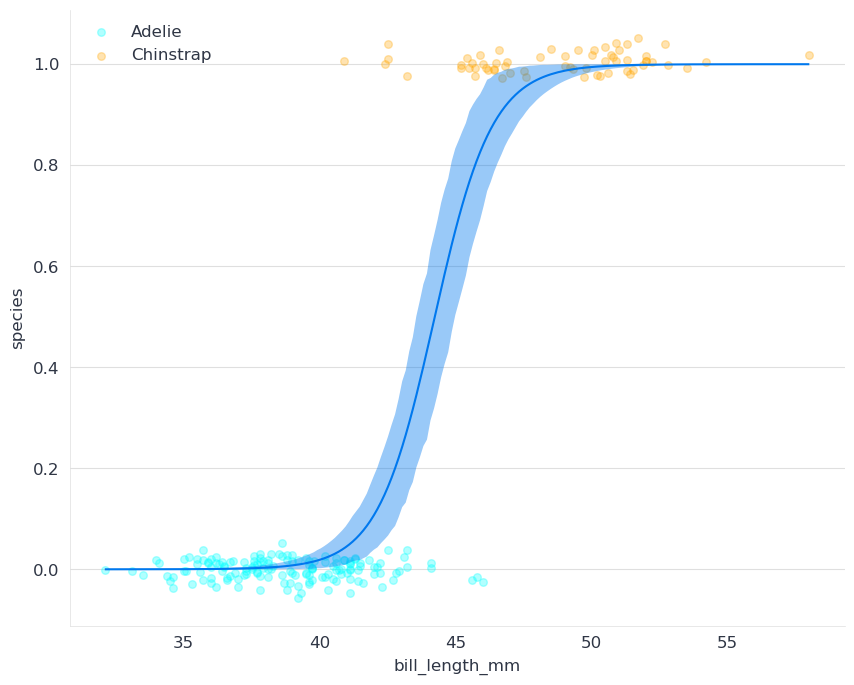

In [113]:
fig, ax = plt.subplots(figsize=(10, 8))  # , layout="constrained"
ax = target_scatter_plot(ax=ax, df=penguins_observed, target_names=['Adelie', 'Chinstrap'],
                         target_vals=[0, 1], target_colors=["cyan", "orange"], alpha=0.3, s=30)
bmb_plots.plot_cap(penguins_lr_model, penguins_lr_idata, covariates="bill_length_mm", ax=ax)
ax.legend();

#### New Predictions


In [114]:
bill_lengths = [30, 40, 50]
new_obs = pd.DataFrame({"bill_length_mm":bill_lengths})
new_obs

,bill_length_mm
0,30
1,40
2,50


In [115]:
# Make predictions here (kind="mean"- does not need observed values)
new_preds_idata = penguins_lr_model.predict(penguins_lr_idata, inplace=False, kind="mean", data=new_obs)
new_preds_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [116]:
new_preds = new_preds_idata.posterior["species_mean"].mean(dim=("chain", "draw")).to_numpy()
new_preds

array([5.03625222e-06, 1.88367099e-02, 9.94489037e-01])

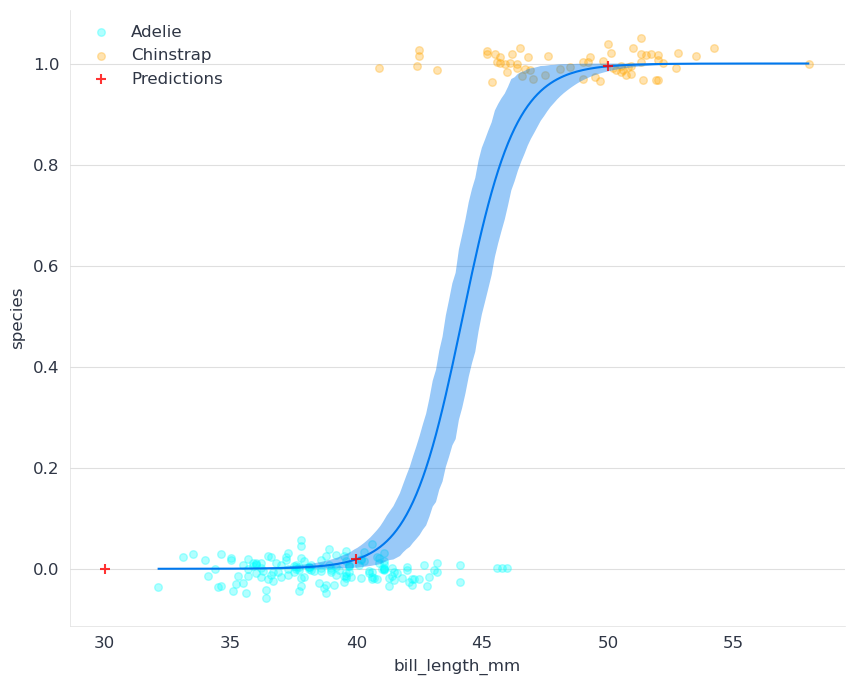

In [122]:
fig, ax = plt.subplots(figsize=(10, 8))  # , layout="constrained"
ax = target_scatter_plot(ax=ax, df=penguins_observed, target_names=['Adelie', 'Chinstrap'],
                         target_vals=[0, 1], target_colors=["cyan", "orange"], alpha=0.3, s=30)
bmb_plots.plot_cap(penguins_lr_model, penguins_lr_idata, covariates="bill_length_mm", ax=ax)

ax.scatter(bill_lengths, new_preds, marker="+", s=50, alpha=0.8, zorder=20, color="red", label="Predictions")
ax.legend();

# Mushroom Toxicity
mushroom dataset provided by the [UCI machine learning repository](https://archive-beta.ics.uci.edu/dataset/73/mushroom). 
* goal- predict mushroom toxicity
The full definition of the dataset can be found in the file [agaricus-lepiota.names](data/agaricus-lepiota.names).

```
7. Attribute Information: (classes: edible=e, poisonous=p)
     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,
                                  knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,
                                  pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,
                                  musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e,
                                  rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l,
                                  none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r,
                                  orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n,
                                  scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p,
                                  urban=u,waste=w,woods=d
```

In [4]:
mushrooms = pd.read_csv("../data/mushrooms.csv")
mushrooms.columns = mushrooms.columns.str.replace(pat="-", repl="_")
print(mushrooms.shape)
mushrooms.head()

(8124, 23)


,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap_shape                 8124 non-null   object
 2   cap_surface               8124 non-null   object
 3   cap_color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill_attachment           8124 non-null   object
 7   gill_spacing              8124 non-null   object
 8   gill_size                 8124 non-null   object
 9   gill_color                8124 non-null   object
 10  stalk_shape               8124 non-null   object
 11  stalk_root                8124 non-null   object
 12  stalk_surface_above_ring  8124 non-null   object
 13  stalk_surface_below_ring  8124 non-null   object
 14  stalk_color_above_ring  

## EDA

In [6]:
# Perform EDA on mushroom dataset
pd.concat(
    [mushrooms["class"].value_counts().rename("count"),
     mushrooms["class"].value_counts(normalize=True).rename("proportion")],
    axis=1)

,count,proportion
class,,
e,4208,0.517971
p,3916,0.482029


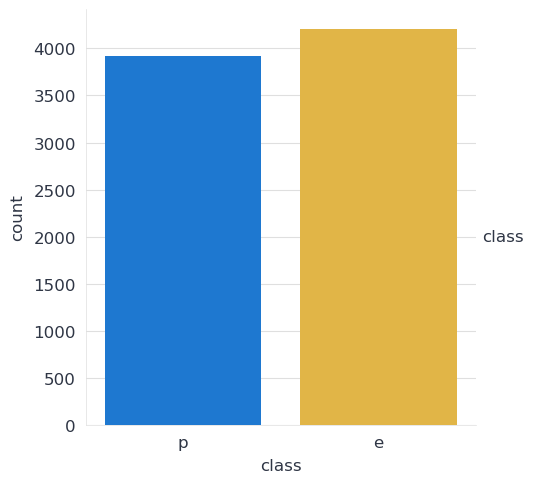

In [7]:
sns.catplot(x="class", kind="count", hue="class", data=mushrooms);

In [8]:
features = ["gill_size", "ring_type", "odor"]
target = "class"

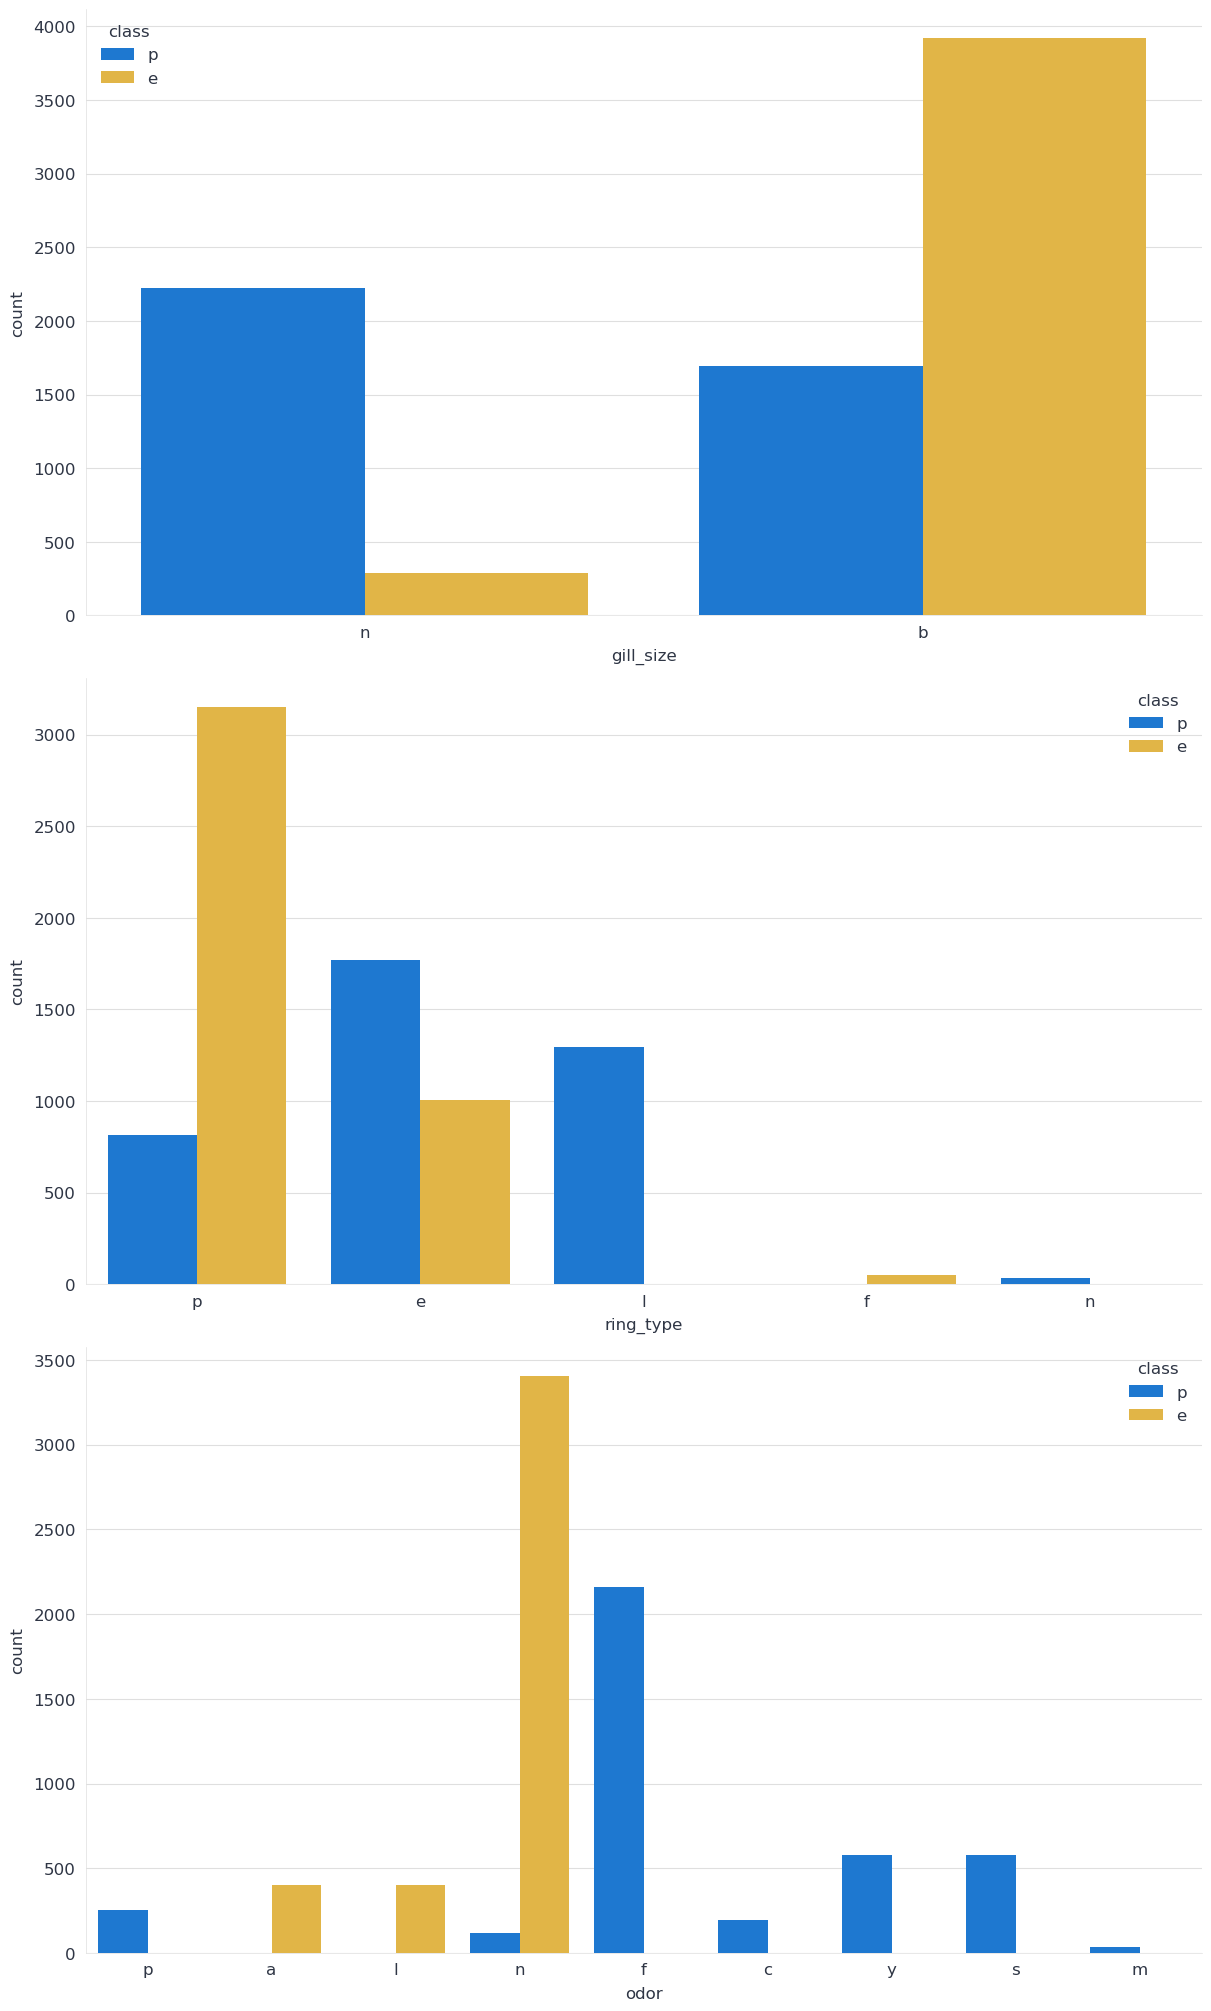

In [9]:
fig, axes = plt.subplots(figsize=(12, 20), nrows=3, ncols=1, layout="constrained")
for ax, feature in zip(axes.ravel(), features):
    sns.countplot(x=feature, hue=target, data=mushrooms, ax=ax)

## Logistic Regression Modeling

Based off of EDA lets try modeling gill-size, ring-type, and odor. from that we can get a sense of which characteristics help us best estimate which mushroom is edible versus those that are not.

Before we run our sampler we'll recode the categorical indicators so its easier to understand their physical meaning in the subsequent plots.

In [10]:
mappings = dict(
  gill_size = dict(b='broad',n='narrow'),
  ring_type = dict(c='cobwebby',e='evanescent',f='flaring', l='large', n='none', p='pendant',s='sheathing', z='zone'),
  odor= dict(a='almond',l='anise',c='creosote',y='fishy',f='foul',m='musty',n='none',p='pungent',s='spicy'))

In [11]:
mushrooms_filtered = (
    mushrooms[["gill_size", "ring_type", "odor", "class"]]
        .replace(to_replace=mappings)
)
mushrooms_filtered

,gill_size,ring_type,odor,class
0,narrow,pendant,pungent,p
1,broad,pendant,almond,e
2,broad,pendant,anise,e
3,narrow,pendant,pungent,p
4,broad,evanescent,none,e
...,...,...,...,...
8119,broad,pendant,none,e
8120,broad,pendant,none,e
8121,broad,pendant,none,e
8122,narrow,evanescent,fishy,p


### Bambi

In [12]:
mushroom_model = bmb.Model(
    formula="class[p] ~ 1 + gill_size + ring_type + odor",
    data=mushrooms_filtered,
    family="bernoulli",
    link="logit")

In [13]:
mushroom_idata = mushroom_model.fit(chains=4, random_seed=1234)
print(mushroom_model)

Modeling the probability that class==p
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, gill_size, ring_type, odor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 441 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.


       Formula: class[p] ~ 1 + gill_size + ring_type + odor
        Family: bernoulli
          Link: p = logit
  Observations: 8124
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9987)
            gill_size ~ Normal(mu: 0.0, sigma: 5.4093)
            ring_type ~ Normal(mu: [0. 0. 0. 0.], sigma: [32.6205  6.8275 37.639   5.0013])
            odor ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0.], sigma: [11.5547 16.4577  9.7405  5.6587 37.639
                5.0438 14.3106  9.7405])

------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


In [14]:
az.summary(mushroom_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-7.495,1.109,-9.514,-5.568
gill_size[narrow],2.714,0.212,2.317,3.112
ring_type[flaring],-27.709,18.267,-60.233,-1.960
ring_type[large],5.079,4.415,-2.425,13.938
ring_type[none],24.112,30.017,-32.963,79.630
ring_type[pendant],0.104,0.207,-0.270,0.500
odor[anise],-9.778,7.310,-23.058,1.733
odor[creosote],20.343,8.191,8.567,35.902
odor[fishy],16.214,4.297,9.628,24.110
odor[foul],15.428,2.266,11.535,19.696


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

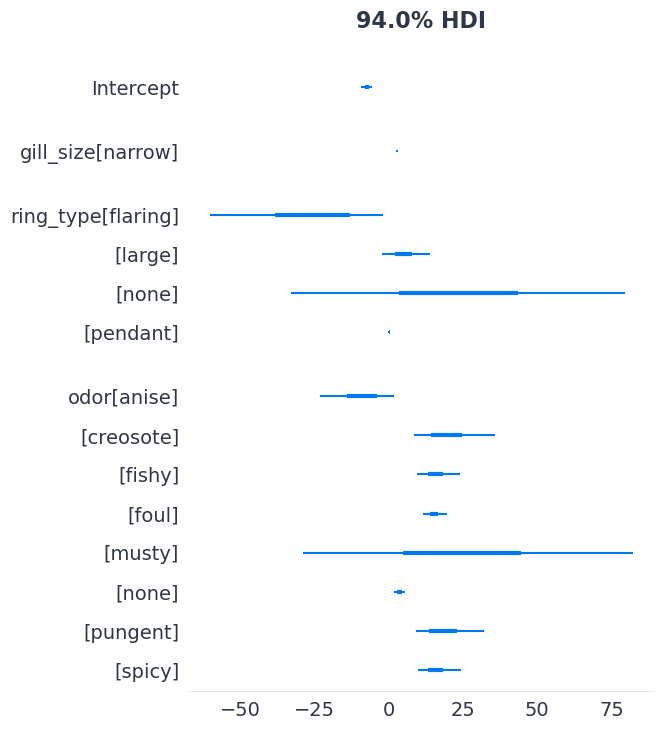

In [15]:
az.plot_forest(mushroom_idata, combined=True)

In [16]:
mushroom_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [17]:
mushroom_idata.extend(mushroom_model.prior_predictive(random_seed=1234))

Sampling: [Intercept, class, gill_size, odor, ring_type]


In [18]:
mushroom_model.predict(mushroom_idata, inplace=True, kind="pps", data=mushrooms_filtered)

In [19]:
mushroom_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Bonus: Create a ridgeplot

Tables can be challenging to understand at a glance. We can also create a ridge plot to get a sense of the range and distribution of the posterior plot. Let's also add a vertical dashed line at 0 to make it easier to see what provides

In [23]:
def plot_forward_samples(idata: az.InferenceData, targets: List[str], title: str, rotation: int=30):
    fig, (left, right) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, layout="constrained")
    xticks = [i + 0.5 for i in range(len(targets))]

    az.plot_ppc(idata, group="prior", ax=left)
    left.set(
        xticks=xticks,
        title="Prior Retrodictive Check",
    )
    left.set_xticklabels(targets, fontsize=14, rotation=rotation)
    left.set_xlabel("Mushroom Toxicity", fontsize=16)
    left.legend(frameon=True, fontsize=11)

    az.plot_ppc(idata, ax=right)
    right.set(
        xticks=xticks,
        title="Posterior Retrodictive Check",
    )
    right.set_xticklabels(targets, fontsize=14, rotation=rotation)
    right.set_xlabel("Mushroom Toxicity", fontsize=16)
    right.legend(frameon=True, fontsize=11)
    fig.suptitle(title)

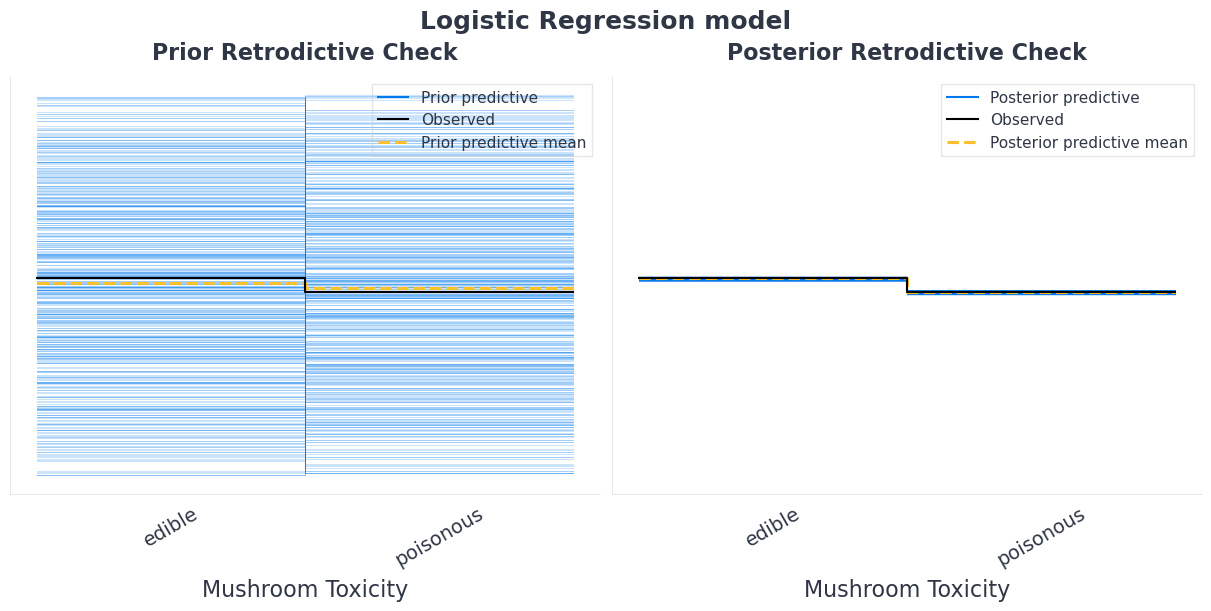

In [24]:
plot_forward_samples(mushroom_idata, targets=["edible", "poisonous"], title="Logistic Regression model")

In [51]:
mushrooms_filtered["class"].value_counts()

class
e    4208
p    3916
Name: count, dtype: int64

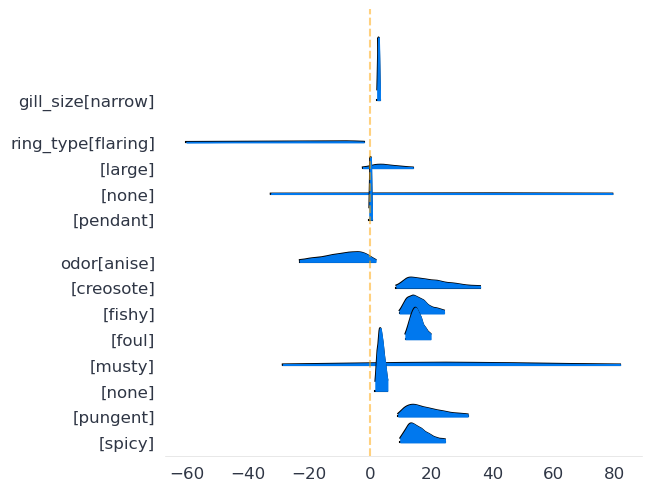

In [52]:
# Ridgeplot
fig, ax = plt.subplots(layout="constrained")  # layout="constrained"
az.plot_forest(
    data=mushroom_idata,
    var_names=["gill_size", "ring_type", "odor"],
    kind="ridgeplot",
    combined=True,
    # ridgeplot_truncate=False,
    # ridgeplot_quantiles=[0.25, 0.5, 0.75],
    # ridgeplot_overlap=0.7,
    # colors="lightgrey",
    ax=ax
)
ax.axvline(x=0, ls="--", lw=1.5, alpha=0.5, color="orange")
plt.show()

## Complete separability
* comparing maximum likelihood estimators with Bayesian estimators in a specific scenario, where one covariate has not observed both classes.
* we pick with a certain gill attachment, but we observe they're all poisonous.
    * a complete class separation.


In [53]:
# All rows where gill attachment is 'a' and the mushrooms are 'poisonous'
poisonous_a_index =  mushrooms.query("gill_attachment == 'a' and `class` == 'p'").index
subset_mushrooms = mushrooms.loc[~mushrooms.index.isin(poisonous_a_index), ["gill_attachment", "ring_number", "class"]]

### EDA 

In [54]:
# Verify that gill_attachemnt a only has edible mushrooms
subset_mushrooms.groupby(["gill_attachment", "ring_number", "class"], as_index=False).size()

,gill_attachment,ring_number,class,size
0,a,o,e,192
1,f,n,p,18
2,f,o,e,3488
3,f,o,p,3808
4,f,t,e,528
5,f,t,p,72


### Maximum Likelihood Estimation
* statsmodels logistic regression is based on maximum likelohood

In [55]:
# Statsmodel requires the output column to be binary so we need to do this conversion ourselves
# Bambi handles this for us automatically!
subset_mushrooms["class_int"] = subset_mushrooms["class"].replace({"e":0, "p":1})

In [56]:
log_reg = smf.logit("class_int ~ 1 + ring_number + gill_attachment", data=subset_mushrooms).fit()

         Current function value: 0.650177
         Iterations: 35


/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
# Inspect summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              class_int   No. Observations:                 8106
Model:                          Logit   Df Residuals:                     8102
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 Dec 2023   Pseudo R-squ.:                 0.06100
Time:                        14:24:48   Log-Likelihood:                -5270.3
converged:                      False   LL-Null:                       -5612.7
Covariance Type:            nonrobust   LLR p-value:                4.212e-148
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.7686   1.49e+04     -0.000      1.000   -2.92e+04    2.92e+04
ring_number[T.o]       -20.4709   6864.890     -0.003      0.998   -1.35e+04    1.34e+04
ring_number[T.t]       -22.5511   6864.890     -0.003      0.997   -1.35e+04    1.34e+04
gill_attachment[T.f]    24.3273   1.32e+04      0.002      0.999   -2.59e+04     2.6e+04
========================================================================================
"""

Explain why the model fails

### Bayesian Regression



In [58]:
# Write the equivalent bambi model here
bmb_lr_model = bmb.Model(
    formula="class_int ~ 1 + ring_number + gill_attachment",
    data=subset_mushrooms,
    family="bernoulli",
    link="logit")
bmb_lr_idata = bmb_lr_model.fit(chains=4, random_seed=1234)

Modeling the probability that class_int==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ring_number, gill_attachment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 320 seconds.


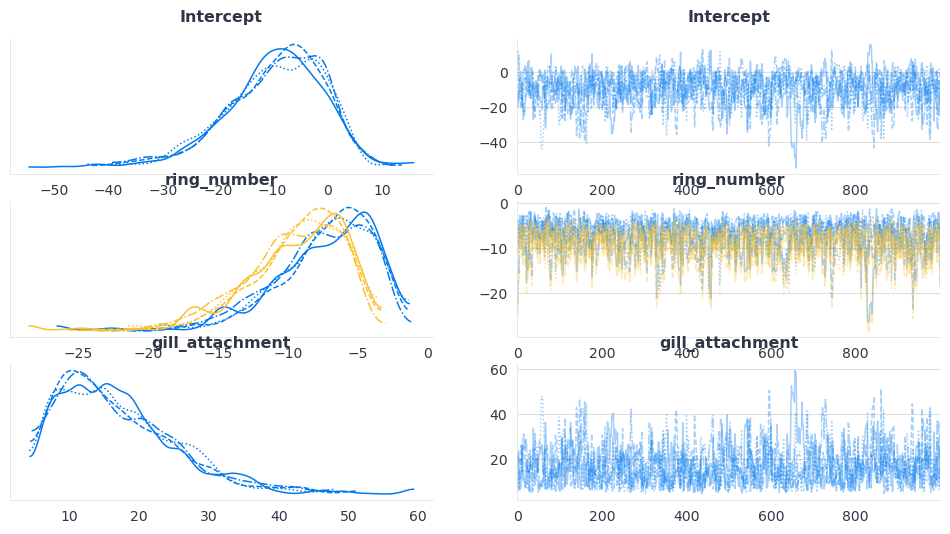

In [59]:
az.plot_trace(bmb_lr_idata);

In [62]:
bmb_lr_model.predict(bmb_lr_idata, inplace=True, kind="pps")

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


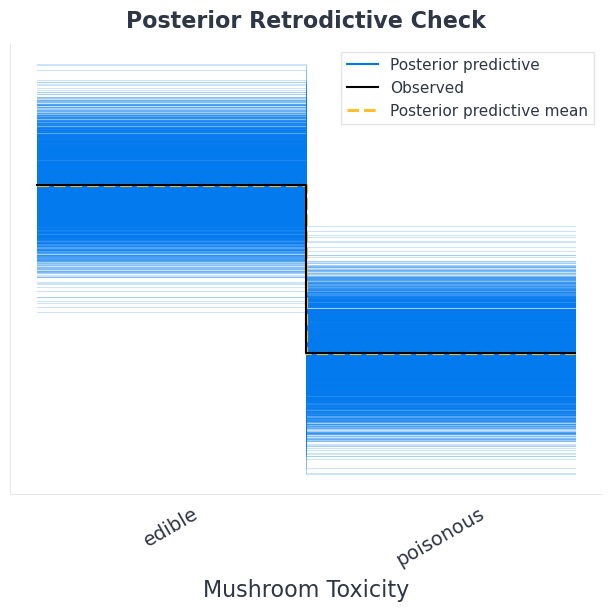

In [66]:
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
az.plot_ppc(bmb_lr_idata, ax=ax)
xticks = [i + 0.5 for i in range(len([0, 1]))]
ax.set(
        xticks=xticks,
        title="Posterior Retrodictive Check",
    )
ax.set_xticklabels(["edible", "poisonous"], fontsize=14, rotation=30)
ax.set_xlabel("Mushroom Toxicity", fontsize=16)
ax.legend(frameon=True, fontsize=11)
plt.show()

In [69]:
az.summary(bmb_lr_idata, var_names=["Intercept", "ring_number", "gill_attachment"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-9.582,9.200,-27.136,5.684,0.393,0.311,586.0,686.0,1.00
ring_number[o],-7.366,3.540,-13.713,-1.858,0.139,0.109,764.0,743.0,1.01
ring_number[t],-9.449,3.545,-15.727,-3.824,0.140,0.107,763.0,740.0,1.01
gill_attachment[f],17.036,8.436,4.838,32.031,0.388,0.288,553.0,714.0,1.00


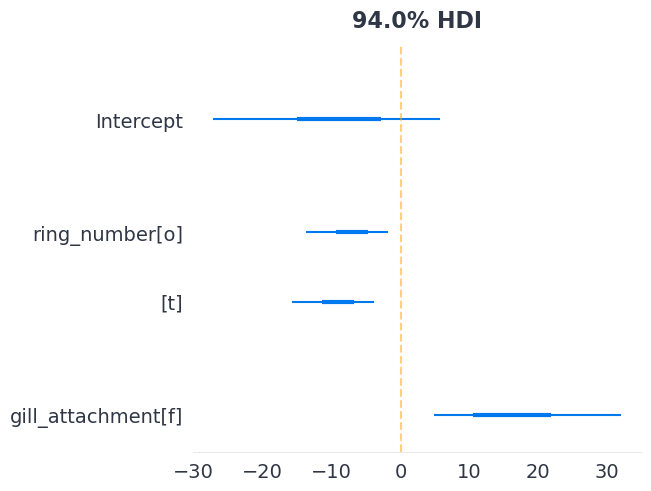

In [70]:
fig, ax = plt.subplots(layout="constrained")
az.plot_forest(
    bmb_lr_idata,
    var_names=["Intercept", "ring_number", "gill_attachment"],
    combined=True,
    ax=ax)
ax.axvline(x=0, color="orange", alpha=0.5, ls="--")
plt.show()

### Discussion
* If the model is seeing all mushrooms are "edible" for a certain gill attachment, then the maximum likelihood of a poisonous mushroom with that gill attachment is zero. 
* However with logistic regression model this is not possible because a sigmoid function has to range from 0 to 1 without including the borders.
    * this means the estimator "pushes" the coefficients to (minus) infinity and that just isn't a useful result.
    * the model diverge
* Bayesian models have priors, which act as a regularization term